# Getting started with WYM

Note: you can run **[this notebook live in Google Colab](https://colab.research.google.com/github/softlab-unimore/WYM/blob/master/quick_start_wym.ipynb)** and use free GPUs provided by Google.

This tutorial describes how to effortlessly explain Entity Matching. Specifically, we will see how to match pairs of tuples (also called data records or table rows) to determine if they refer to the same real world entity. To do so, we will need labeled examples as input, i.e., tuple pairs which have been annotated as matches or non-matches. This will be used to train a model to explain using supervised learning.

## Step 0. Setup

If you are running this notebook inside Colab, you will first need to install necessary packages by running the code below:

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 14eQiG9sYM4LcCfJbwnoUgxZ0-PfpsWkQ -O ABT-BUY-data.zip
!unzip ABT-BUY-data.zip

/home/giacomo.guiduzzi/anaconda3/lib/python3.8/site-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14eQiG9sYM4LcCfJbwnoUgxZ0-PfpsWkQ
To: /dati/home/giacomo.guiduzzi/ABT-BUY-data.zip
100%|██████████████████████████████████████| 39.6M/39.6M [00:00<00:00, 53.7MB/s]
Archive:  ABT-BUY-data.zip
   creating: Abt-Buy/
  inflating: Abt-Buy/train_simplified.csv  
  inflating: Abt-Buy/test_simplified.csv  
   creating: Abt-Buy/.ipynb_checkpoints/
  inflating: Abt-Buy/train_merged.csv  
  inflating: Abt-Buy/valid_simplified.csv  
  inflating: Abt-Buy/valid_merged.csv  
  inflating: Abt-Buy/test_merged.csv  
  inflating: Abt-Buy/best_model.pth  
  inflating: Abt-Buy/cacheddata.pth  


## Clone WYM

In [ ]:
!git clone https://github.com/softlab-unimore/wym.git

Cloning into 'wym'...
remote: Enumerating objects: 444, done.
remote: Counting objects: 100% (444/444), done.
remote: Compressing objects: 100% (288/288), done.
remote: Total 444 (delta 305), reused 283 (delta 150), pack-reused 0
Receiving objects: 100% (444/444), 3.00 MiB | 11.73 MiB/s, done.
Resolving deltas: 100% (305/305), done.


In [ ]:
!pip install -e wym

Obtaining file:///dati/home/giacomo.guiduzzi/wym
  Preparing metadata (setup.py) ... - done
  Attempting uninstall: wym
    Found existing installation: wym 1.0.0
    Uninstalling wym-1.0.0:
      Successfully uninstalled wym-1.0.0
  Running setup.py develop for wym


### Load data for entity matching

Now let's get some sample data to play with in this tutorial.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [ ]:
# dataset_path = '/content/Abt-Buy/'
dataset_path = 'Abt-Buy/'

simplified_columns = ['id','left_id','right_id','label','left_name','right_name']
train_df = pd.read_csv(dataset_path + 'train_merged.csv')[simplified_columns].iloc[:].copy()
valid_df = pd.read_csv(dataset_path + 'valid_merged.csv')[simplified_columns].iloc[:500].copy()
test_df = pd.read_csv(dataset_path + 'test_merged.csv')[simplified_columns].iloc[:500].copy()

# train_df.to_csv(dataset_path + 'train_simplified.csv', index=False)
# valid_df.to_csv(dataset_path + 'valid_simplified.csv', index=False)
# test_df.to_csv(dataset_path + 'test_simplified.csv', index=False)

exclude_attrs=['id','left_id','right_id', 'label']

In [ ]:
train_df

,id,left_id,right_id,label,left_name,right_name
0,0,730,775,0,lg 24 ' lds4821ww semi integrated built in whi...,lg ldf6920bb fully integrated dishwasher
1,1,731,775,0,lg 24 ' lds4821bb semi integrated built in bla...,lg ldf6920bb fully integrated dishwasher
2,2,735,775,1,lg 24 ' ldf6920bb fully integrated built in bl...,lg ldf6920bb fully integrated dishwasher
3,3,732,775,0,lg 24 ' ldf6920ww fully integrated built in wh...,lg ldf6920bb fully integrated dishwasher
4,4,734,775,0,lg 24 ' ldf6920st fully integrated built in st...,lg ldf6920bb fully integrated dishwasher
...,...,...,...,...,...,...
5738,5738,429,226,1,electrolux harmony series canister vacuum el6985b,"harmony el6985a vacuum ( canister , hepa )"
5739,5739,1072,623,1,lasonic atsc digital to analog tv converter bo...,lasonic lta-260 atsc converter box
5740,5740,149,270,1,waring professional cool-touch deep fryer blac...,waring pro deep fryer 3qt - black
5741,5741,518,404,1,bracketron ipod docking kit ipm202bl,bracketron ipod docking kit


# WYM


In [ ]:
from wym.wym import Wym

In [ ]:
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

## Initialize WYM
Using pre-trained `bert-base-uncased` as default

In [ ]:
wym = Wym(df=train_df, exclude_attrs=exclude_attrs, batch_size=512, reset_networks=True)

X, y = train_df[wym.columns_to_use], train_df['label']
X_valid, y_valid = valid_df[wym.columns_to_use], valid_df['label']
X_test, y_test = test_df[wym.columns_to_use], test_df['label']

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Fit
X_valid, y_valid are optional, if None they are copied from X, y

In [ ]:
wym.fit(X, y, X_valid, y_valid)

Computing embedding


  0%|          | 0/12 [00:00<?, ?it/s]

Computing embedding


  0%|          | 0/12 [00:00<?, ?it/s]

generating word_pairs


  0%|          | 0/5743 [00:00<?, ?it/s]

Computing embedding


  0%|          | 0/1 [00:00<?, ?it/s]

Computing embedding


  0%|          | 0/1 [00:00<?, ?it/s]

generating word_pairs


/dati/home/giacomo.guiduzzi/WYM_Test/wym_github/wym/WordPairGenerator.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'] = df.index


  0%|          | 0/500 [00:00<?, ?it/s]

resetting networks
Epoch   1/40: train Loss: 0.5343 MSELoss(): 0.0526 std: 0.2296	|	valid Loss: 0.3814 MSELoss(): 0.0094 std: 0.2323
Epoch   2/40: train Loss: 0.4358 MSELoss(): 0.0148 std: 0.2464	|	valid Loss: 0.3615 MSELoss(): 0.0051 std: 0.2450
Epoch   3/40: train Loss: 0.4283 MSELoss(): 0.0121 std: 0.2323	|	valid Loss: 0.3593 MSELoss(): 0.0049 std: 0.2513
Epoch   4/40: train Loss: 0.4253 MSELoss(): 0.0113 std: 0.2499	|	valid Loss: 0.3590 MSELoss(): 0.0049 std: 0.2119
Epoch   5/40: train Loss: 0.4222 MSELoss(): 0.0105 std: 0.2461	|	valid Loss: 0.3573 MSELoss(): 0.0046 std: 0.2280
Epoch   6/40: train Loss: 0.4204 MSELoss(): 0.0101 std: 0.2401	|	valid Loss: 0.3568 MSELoss(): 0.0046 std: 0.2292
Epoch   7/40: train Loss: 0.4185 MSELoss(): 0.0097 std: 0.2409	|	valid Loss: 0.3555 MSELoss(): 0.0045 std: 0.2432
Epoch   8/40: train Loss: 0.4169 MSELoss(): 0.0093 std: 0.2395	|	valid Loss: 0.3522 MSELoss(): 0.0040 std: 0.2504
Epoch   9/40: train Loss: 0.4152 MSELoss(): 0.0089 std: 0.2489	|	vali

  0%|          | 0/2 [00:00<?, ?it/s]

/home/giacomo.guiduzzi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/giacomo.guiduzzi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/giacomo.guiduzzi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/giacomo.guiduzzi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: Co

before feature selection


### Predict

In [ ]:
wym.predict(X_test)

Computing embedding


  0%|          | 0/1 [00:00<?, ?it/s]

Computing embedding


  0%|          | 0/1 [00:00<?, ?it/s]

generating word_pairs


/dati/home/giacomo.guiduzzi/WYM_Test/wym_github/wym/WordPairGenerator.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'] = df.index


  0%|          | 0/500 [00:00<?, ?it/s]

array([1.97158432e-02, 5.74931899e-06, 2.92399496e-03, 7.50173508e-03,
       5.02586673e-01, 1.13556428e-03, 2.59480162e-02, 3.57988297e-02,
       3.02466437e-02, 1.35806853e-02, 3.41737008e-03, 5.47858953e-04,
       9.04880960e-03, 4.34539666e-04, 3.85969268e-01, 1.00029510e-01,
       1.24364563e-04, 3.80655284e-03, 9.60569929e-02, 4.57413729e-03,
       4.85057980e-03, 1.11151551e-02, 2.43138803e-02, 1.58517278e-01,
       3.68250702e-03, 5.18191656e-03, 3.86544863e-04, 4.75792910e-04,
       1.68261461e-05, 4.74235241e-02, 1.80717458e-03, 1.55058451e-02,
       7.87708784e-02, 4.60742847e-02, 1.58457240e-02, 1.07905659e-02,
       1.40838546e-02, 8.86914770e-03, 1.39563637e-04, 1.32389730e-02,
       5.16086005e-03, 4.76096301e-03, 6.79229574e-03, 1.28108553e-01,
       4.10189167e-05, 1.51877639e-02, 2.40101645e-02, 2.26510180e-02,
       5.37788004e-02, 4.43164550e-05, 4.61645946e-05, 1.45053931e-02,
       3.87682395e-02, 1.52087259e-02, 1.04940901e-02, 4.99014231e-04,
      

In [ ]:
match_score, data_dict, word_pairs, emb_pairs, features, word_relevance = wym.predict(X_test, return_data=True)

Computing embedding


  0%|          | 0/1 [00:00<?, ?it/s]

Computing embedding


  0%|          | 0/1 [00:00<?, ?it/s]

generating word_pairs


  0%|          | 0/500 [00:00<?, ?it/s]

### Explain

In [ ]:
pd.Series(match_score).describe()

count    500.000000
mean       0.035248
std        0.128961
min        0.000004
25%        0.000326
50%        0.003332
75%        0.013429
max        0.944960
dtype: float64

#### Positive element

In [ ]:
positive = match_score > .5

In [ ]:
id = test_df[positive]['id'].values[2]
test_df[positive]

,id,left_id,right_id,label,left_name,right_name
4,4,241,415,0,sony lcs-twa/r red soft leather carrying case ...,sony lcs-twa/b cyber-shot camera case lcstwa/b
144,144,797,259,1,canon battery charger 1133b001,canon cb-2lx battery charger 1133b001
199,199,161,237,1,sirius sportster 4 with car kit sp4tk1,directed electronics sportster 4 sirius satell...
275,275,805,470,1,canon deluxe grey leather case 2349b001,canon psc-1000 semi-hard leather case 2349b001
283,283,650,666,0,samsung 40 ' series 7 lcd black flat panel hdt...,samsung ln40a650 40 ' lcd tv
284,284,568,666,1,samsung 40 ' series 6 lcd black flat panel hdt...,samsung ln40a650 40 ' lcd tv
287,287,695,744,1,samsung 67 ' black widescreen series 7 led dlp...,samsung hl-67a750 67 ' widescreen 1080p dlp hd...
311,311,191,138,1,panasonic kx-tga450b black 5.8 ghz cordless ha...,panasonic kx-tga450b cordless handset
340,340,944,954,1,toshiba 42 ' regza theaterwide black flat pane...,toshiba 42rv535u 42 ' widescreen 1080p lcd hdt...
382,382,365,273,1,linksys wireless-g printserver wpsm54g,linksys wpsm54g wireless-g usb print server


match score : 0.9450


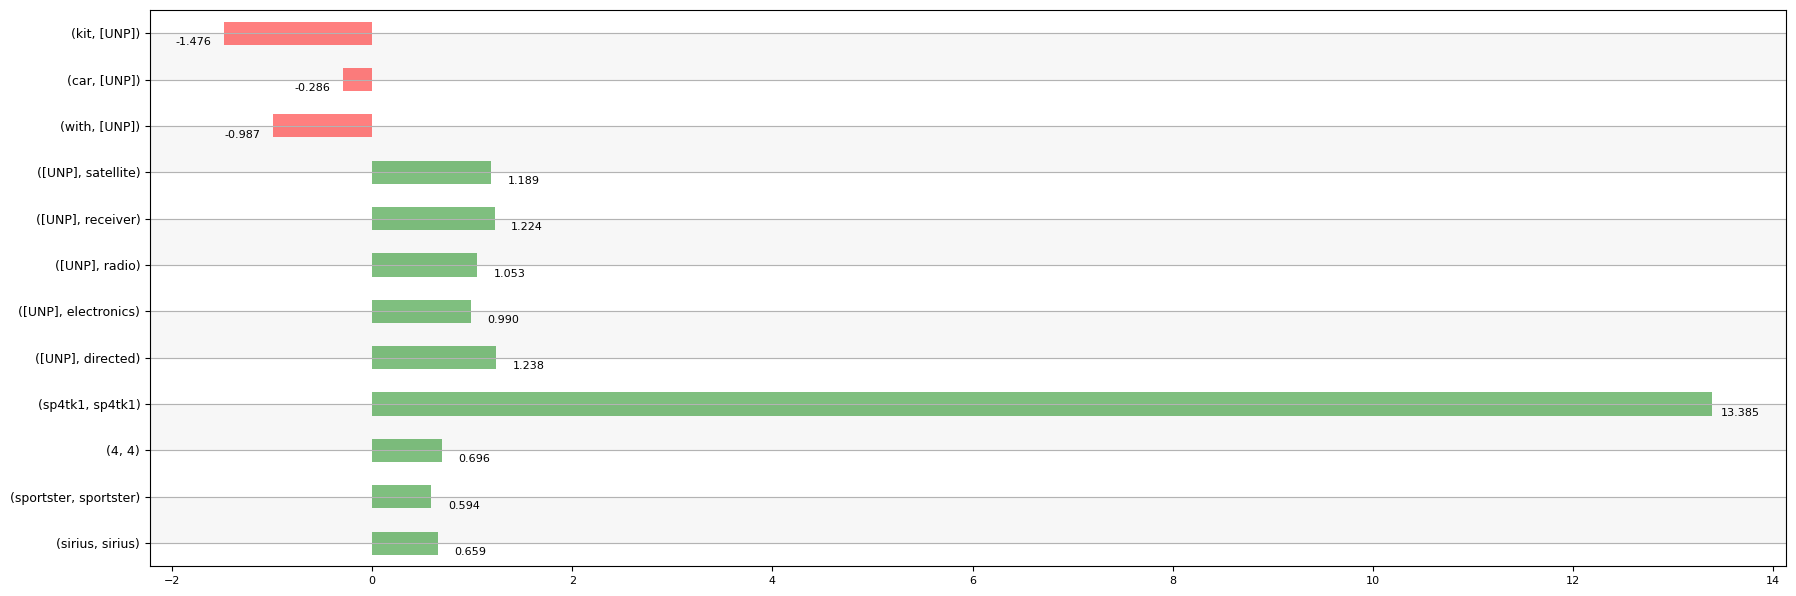

,id,left_id,right_id,label,left_name,right_name
199,199,161,237,1,sirius sportster 4 with car kit sp4tk1,directed electronics sportster 4 sirius satell...


In [ ]:
el_exp = word_relevance.query(f'id == {id}')
print(f'match score : {match_score[id]:.4f}')
wym.plot_token_contribution(el_exp, cut=0)
test_df.query(f'id == {id}')

#### Negative element

In [ ]:
id = 0

match score : 0.0197


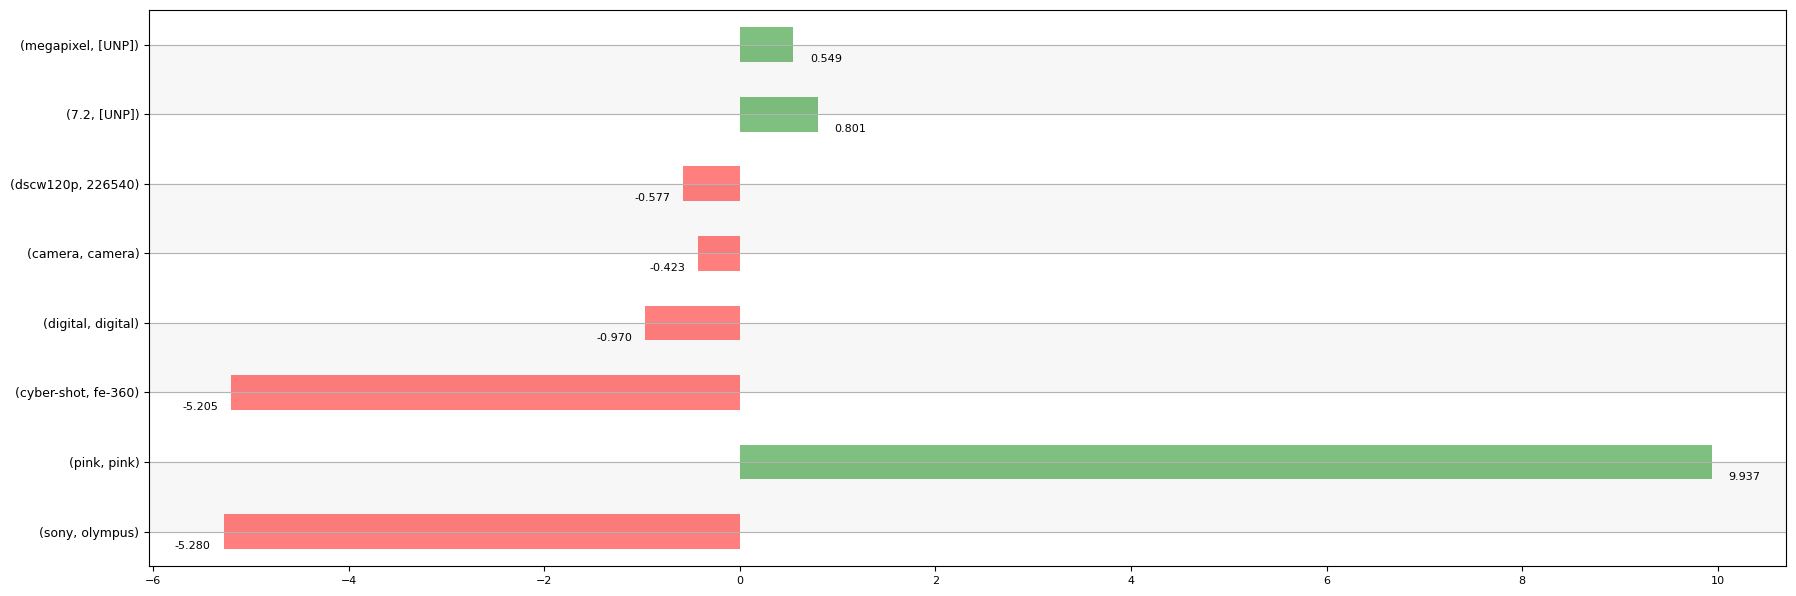

,id,left_id,right_id,label,left_name,right_name
0,0,445,910,0,sony pink cyber-shot 7.2 megapixel digital cam...,olympus fe-360 digital camera pink 226540


In [ ]:
el_exp = word_relevance.query(f'id == {id}')
print(f'match score : {match_score[id]:.4f}')
wym.plot_token_contribution(el_exp, cut=0)
test_df.query(f'id == {id}')